In [67]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import KFold
import torch.nn as nn
# Define the FastF1Dataset class
class FastF1Dataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length + 1

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx:idx + self.sequence_length], dtype=torch.float32)

# Load your saved model
def load_model(model_path, model_class, sequence_length, input_dim, device):
    model = model_class(sequence_length, input_dim)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

def compute_reconstruction_error(inputs, outputs):
    # List of column indices you want to keep
    column_indices = [0, 1, 3, 4, 11, 12, 13, 14, 15, 16, 17, 18, 24]

    selected_inputs = inputs[:, :, column_indices]
    selected_outputs = outputs[:, :, column_indices]
    print(f'shapes: {selected_inputs.shape}, {selected_outputs.shape}')
    return torch.mean((selected_inputs - selected_outputs) ** 2, dim=(1, 2)).detach().cpu().numpy()

# Calculate reconstruction error
def compute_reconstruction_error_2(inputs, outputs):
    # List of column indices you want to keep
    column_indices = [0, 1, 3, 4, 11, 12, 13, 14, 15, 16, 17, 18, 24]

    selected_inputs = inputs[:, :, column_indices]
    selected_outputs = outputs[:, :, column_indices]
    print(f'shapes: {selected_inputs.shape}, {selected_outputs.shape}')
    return torch.mean((selected_inputs - selected_outputs) ** 2, dim=(1)).detach().cpu().numpy()


# Define your autoencoder class
class LSTMAutoencoder(nn.Module):
    def __init__(self, sequence_length, num_features):
        super(LSTMAutoencoder, self).__init__()
        self.encoder = nn.LSTM(num_features, 64, batch_first=True)
        self.latent = nn.LSTM(64, 32, batch_first=True)
        self.decoder = nn.LSTM(32, 64, batch_first=True)
        self.output_layer = nn.Linear(64, num_features)

    def forward(self, x):
        x, _ = self.encoder(x)
        x, _ = self.latent(x[:, -1].unsqueeze(1).repeat(1, x.size(1), 1))
        x, _ = self.decoder(x)
        x = self.output_layer(x)
        return x

# Set paths and parameters
# model_path = "AD_19-23_autoencoder_AdamW_lr0001_loss0.4037_fold5.pth"
model_path = "AD_19-23_autoencoder_AdamW_lr0001_ep15_loss0.3210.pth"
new_data_path = "C:/2024-P3-F1LLM/Dataset/train_data_only_failures/2024_LasVegasGrandPrix_MinMaxScaler_normalized_10_Engine.npz"
sequence_length = 20
threshold = 500

# Load the new data
new_data = np.load(new_data_path, allow_pickle=True)['data']
new_data = new_data[:, :-1]
new_data = np.delete(new_data, -4, axis= 1)
new_data_array = np.array(new_data, dtype=np.float32)

# Create the test dataset and data loader
test_dataset = FastF1Dataset(new_data_array, sequence_length)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = new_data_array.shape[1]  # Number of features per timestep
autoencoder = load_model(model_path, LSTMAutoencoder, sequence_length, input_dim, device).to(device)

# Test the model
def test_autoencoder(autoencoder, data_loader, device):
    autoencoder.eval()
    errors = []
    errors_2 = []

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch.to(device)
            outputs = autoencoder(inputs)
            batch_errors = compute_reconstruction_error(inputs, outputs)
            batch_errors_2 = compute_reconstruction_error_2(inputs, outputs)
            errors.extend(batch_errors)
            errors_2.extend(batch_errors_2)

    return np.array(errors), np.array(errors_2)

 # Scalar per sequence

reconstruction_errors, reconstruction_errors_2 = test_autoencoder(autoencoder, test_loader, device)

# Set a threshold for anomalies


shapes: torch.Size([32, 20, 13]), torch.Size([32, 20, 13])
shapes: torch.Size([32, 20, 13]), torch.Size([32, 20, 13])
shapes: torch.Size([32, 20, 13]), torch.Size([32, 20, 13])
shapes: torch.Size([32, 20, 13]), torch.Size([32, 20, 13])
shapes: torch.Size([32, 20, 13]), torch.Size([32, 20, 13])
shapes: torch.Size([32, 20, 13]), torch.Size([32, 20, 13])
shapes: torch.Size([32, 20, 13]), torch.Size([32, 20, 13])
shapes: torch.Size([32, 20, 13]), torch.Size([32, 20, 13])
shapes: torch.Size([32, 20, 13]), torch.Size([32, 20, 13])
shapes: torch.Size([32, 20, 13]), torch.Size([32, 20, 13])
shapes: torch.Size([32, 20, 13]), torch.Size([32, 20, 13])
shapes: torch.Size([32, 20, 13]), torch.Size([32, 20, 13])
shapes: torch.Size([32, 20, 13]), torch.Size([32, 20, 13])
shapes: torch.Size([32, 20, 13]), torch.Size([32, 20, 13])
shapes: torch.Size([32, 20, 13]), torch.Size([32, 20, 13])
shapes: torch.Size([32, 20, 13]), torch.Size([32, 20, 13])
shapes: torch.Size([32, 20, 13]), torch.Size([32, 20, 13

In [68]:
#new_data (npz) to pandas
import pandas as pd
race_df = pd.DataFrame(new_data)

cols = [
       'SessionTime',
       'Time_in_ms',
       'LapNumber',
       'Position',
       'Speed',
       'AirTemp',
       'Humidity',
       'Pressure',
       'TrackTemp',
       'WindDirection',
       'WindSpeed',
       'DistanceToDriverAhead',
       'RPM',
       'nGear',
       'Throttle',
       'X',
       'Y',
       'Z',
       'Distance',
       'TyreLife',
       'DriverNumber',
       'Compound',
       'Team',
       'TrackStatus',
       'Rainfall',
       # 'DriverAhead',
       'Brake',
       'DRS',
       'Event'
    ]

race_df.columns = cols
#first 50 rows of tyrelife
race_df

,SessionTime,Time_in_ms,LapNumber,Position,Speed,AirTemp,Humidity,Pressure,TrackTemp,WindDirection,...,Z,Distance,TyreLife,Compound,Team,TrackStatus,Rainfall,Brake,DRS,Event
0,0.000000,0.003031,0.0,0.0,0.000000,1.0,1.0,0.25,0.714286,1.000000,...,0.393939,0.000000,0.000000,2.0,4.0,1.0,0.0,0.0,0.0,19.0
1,0.000068,0.003932,0.0,0.0,0.019391,1.0,1.0,0.25,0.714286,1.000000,...,0.393939,0.000048,0.000000,2.0,4.0,1.0,0.0,0.0,0.0,19.0
2,0.000208,0.005778,0.0,0.0,0.041551,1.0,1.0,0.25,0.714286,1.000000,...,0.387879,0.000217,0.000000,2.0,4.0,1.0,0.0,0.0,0.0,19.0
3,0.000238,0.006164,0.0,0.0,0.049861,1.0,1.0,0.25,0.714286,1.000000,...,0.393939,0.000259,0.000000,2.0,4.0,1.0,0.0,0.0,0.0,19.0
4,0.000368,0.007881,0.0,0.0,0.058172,1.0,1.0,0.25,0.714286,1.000000,...,0.393939,0.000479,0.000000,2.0,4.0,1.0,0.0,0.0,0.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11653,0.999703,0.948928,1.0,1.0,0.218837,0.0,0.0,1.00,0.000000,0.612121,...,0.545455,0.996373,0.444444,3.0,4.0,1.0,0.0,0.0,0.0,19.0
11654,0.999858,0.950980,1.0,1.0,0.218837,0.0,0.0,1.00,0.000000,0.612121,...,0.545455,0.997224,0.444444,3.0,4.0,1.0,0.0,0.0,0.0,19.0
11655,0.999859,0.950988,1.0,1.0,0.218837,0.0,0.0,1.00,0.000000,0.612121,...,0.545455,0.997227,0.444444,3.0,4.0,1.0,0.0,0.0,0.0,19.0
11656,0.999975,0.952525,1.0,1.0,0.218837,0.0,0.0,1.00,0.000000,0.612121,...,0.545455,0.997869,0.444444,3.0,4.0,1.0,0.0,0.0,0.0,19.0


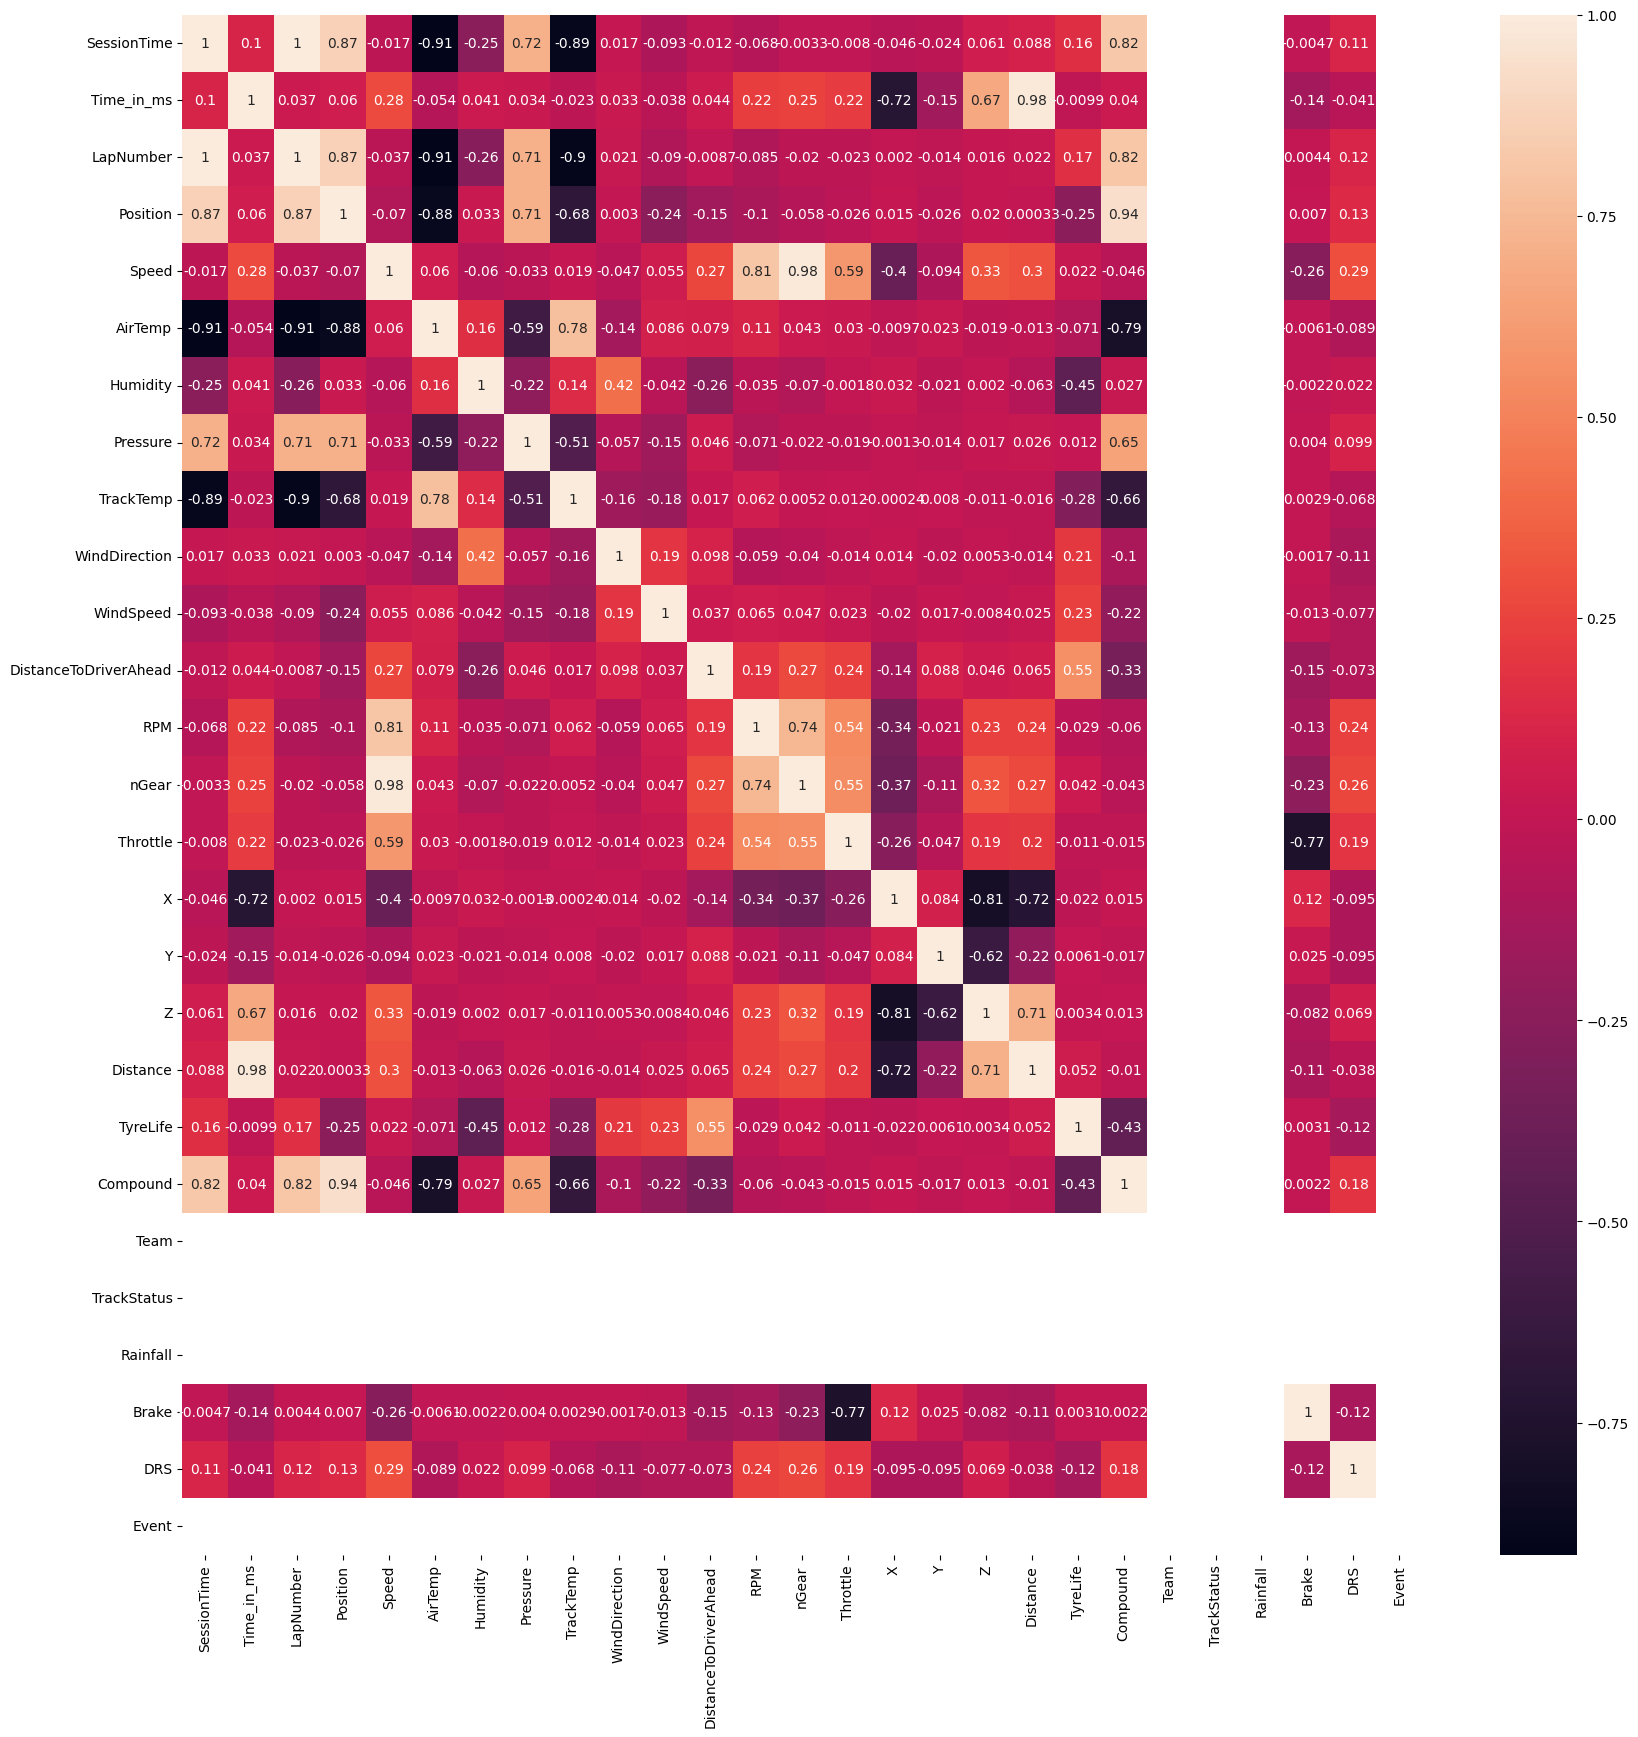

In [69]:
#correlation matrix, big
import seaborn as sns
plt.figure(figsize=(20, 20))
sns.heatmap(race_df.corr(), annot=True)

plt.show()

In [70]:
len(new_data)

11658

In [71]:
def plot_reconstruction_errors_with_threshold(errors, threshold=None):
    """
    Plots reconstruction errors as a line graph with an optional threshold.

    Parameters:
        errors (np.array): Array of reconstruction errors.
        threshold (float, optional): Threshold for detecting anomalies. Defaults to None.
    """
    plt.figure(figsize=(30, 12))
    plt.plot(errors, label="Reconstruction Errors", color='blue', linewidth=4)
    
    if threshold is not None:
        plt.axhline(y=threshold, color='red', linestyle='--', label="Threshold", linewidth=4)
    
    plt.xlabel("Sample Index", fontsize=40)
    plt.xticks(range(0, len(errors), 2000), fontsize=35)
    plt.yticks(fontsize=35)
    plt.ylabel("Reconstruction Error", fontsize=40)
    # plt.title("Reconstruction Errors with Threshold", fontsize=30)
    
    # Aggiungi legenda una sola volta
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    #change legend font size
    plt.legend(by_label.values(), by_label.keys(), prop={'size': 35})
    plt.subplots_adjust(left=0.07, right=0.93, top=0.9, bottom=0.1)
    #show the axis
    plt.axvline(x=0, color='black', linewidth=2)
    plt.axhline(y=0, color='black', linewidth=2)
    
    plt.grid(alpha=0.3)
    plt.savefig("reconstruction_errors.png")
    plt.show()

In [72]:
# threshold = np.mean(reconstruction_errors) + 3 * np.std(reconstruction_errors)
# threshold = np.percentile(reconstruction_errors, 99.9)
threshold = 0.50
# Visualize errors
# visualize_reconstruction_errors(reconstruction_errors, threshold=threshold)

# Print anomalies
anomalies = reconstruction_errors > threshold
print(f"Total anomalies detected: {np.sum(anomalies)}")

Total anomalies detected: 0


In [76]:
relevant_cols = [
       'SessionTime_in_ms',
       'Time_in_ms',
       # 'LapNumber', # non influisce sull'anomalia
       'Position',
       'Speed',
       # 'AirTemp', # non influisce sull'anomalia
       # 'Humidity', # non influisce sull'anomalia
       # 'Pressure', # non influisce sull'anomalia
       # 'TrackTemp', # non influisce sull'anomalia
       # 'WindDirection', # non influisce sull'anomalia
       # 'WindSpeed', # non influisce sull'anomalia
       'DistanceToDriverAhead',
       'RPM',
       'nGear',
       'Throttle',
       'X',
       'Y',
       'Z',
       'Distance',
       # 'TyreLife', # non influisce sull'anomalia
       # 'Compound', # non influisce sull'anomalia
       # 'Team', # non influisce sull'anomalia
       # 'TrackStatus', # non influisce sull'anomalia
       # 'Rainfall', # non influisce sull'anomalia
       'Brake',
       # 'DRS', # non influisce sull'anomalia
       # 'Event', # non influisce sull'anomalia
]

In [78]:
reconstruction_errors_by_feature_df = pd.DataFrame(reconstruction_errors_2, columns=relevant_cols)
def plot_reconstruction_errors_with_threshold(errors, threshold=None):
    """
    Plots reconstruction errors as a line graph with an optional threshold.

    Parameters:
        errors (np.array): Array of reconstruction errors.
        threshold (float, optional): Threshold for detecting anomalies. Defaults to None.
    """
    plt.figure(figsize=(30, 12))
    for col in errors.columns:
        # if not col in ['Brake']:
        # if col in ['Speed', 'Throttle', 'WindSpeed', 'Rainfall']:
            plt.plot(errors[col], label=col, linewidth=4)

    if threshold is not None:
        plt.axhline(y=threshold, color='red', linestyle='--', label="Threshold", linewidth=4)

    plt.xlabel("Sample Index", fontsize=40)
    plt.xticks(range(0, errors.shape[0], 2000), fontsize=35)
    plt.yticks(fontsize=35)
    plt.ylabel("Reconstruction Error", fontsize=40)
    # plt.title("Reconstruction Errors with Threshold", fontsize=30)

    # Aggiungi legenda una sola volta
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    #change legend font size
    plt.legend(by_label.values(), by_label.keys(), prop={'size': 35}, loc="upper right", bbox_to_anchor=(1.3, 1))
    plt.subplots_adjust(left=0.07, right=0.93, top=0.9, bottom=0.1)
    #show the axis
    plt.axvline(x=0, color='black', linewidth=2)
    plt.axhline(y=0, color='black', linewidth=2)

    plt.grid(alpha=0.3)
    plt.savefig("reconstruction_errors.png")
    plt.show()


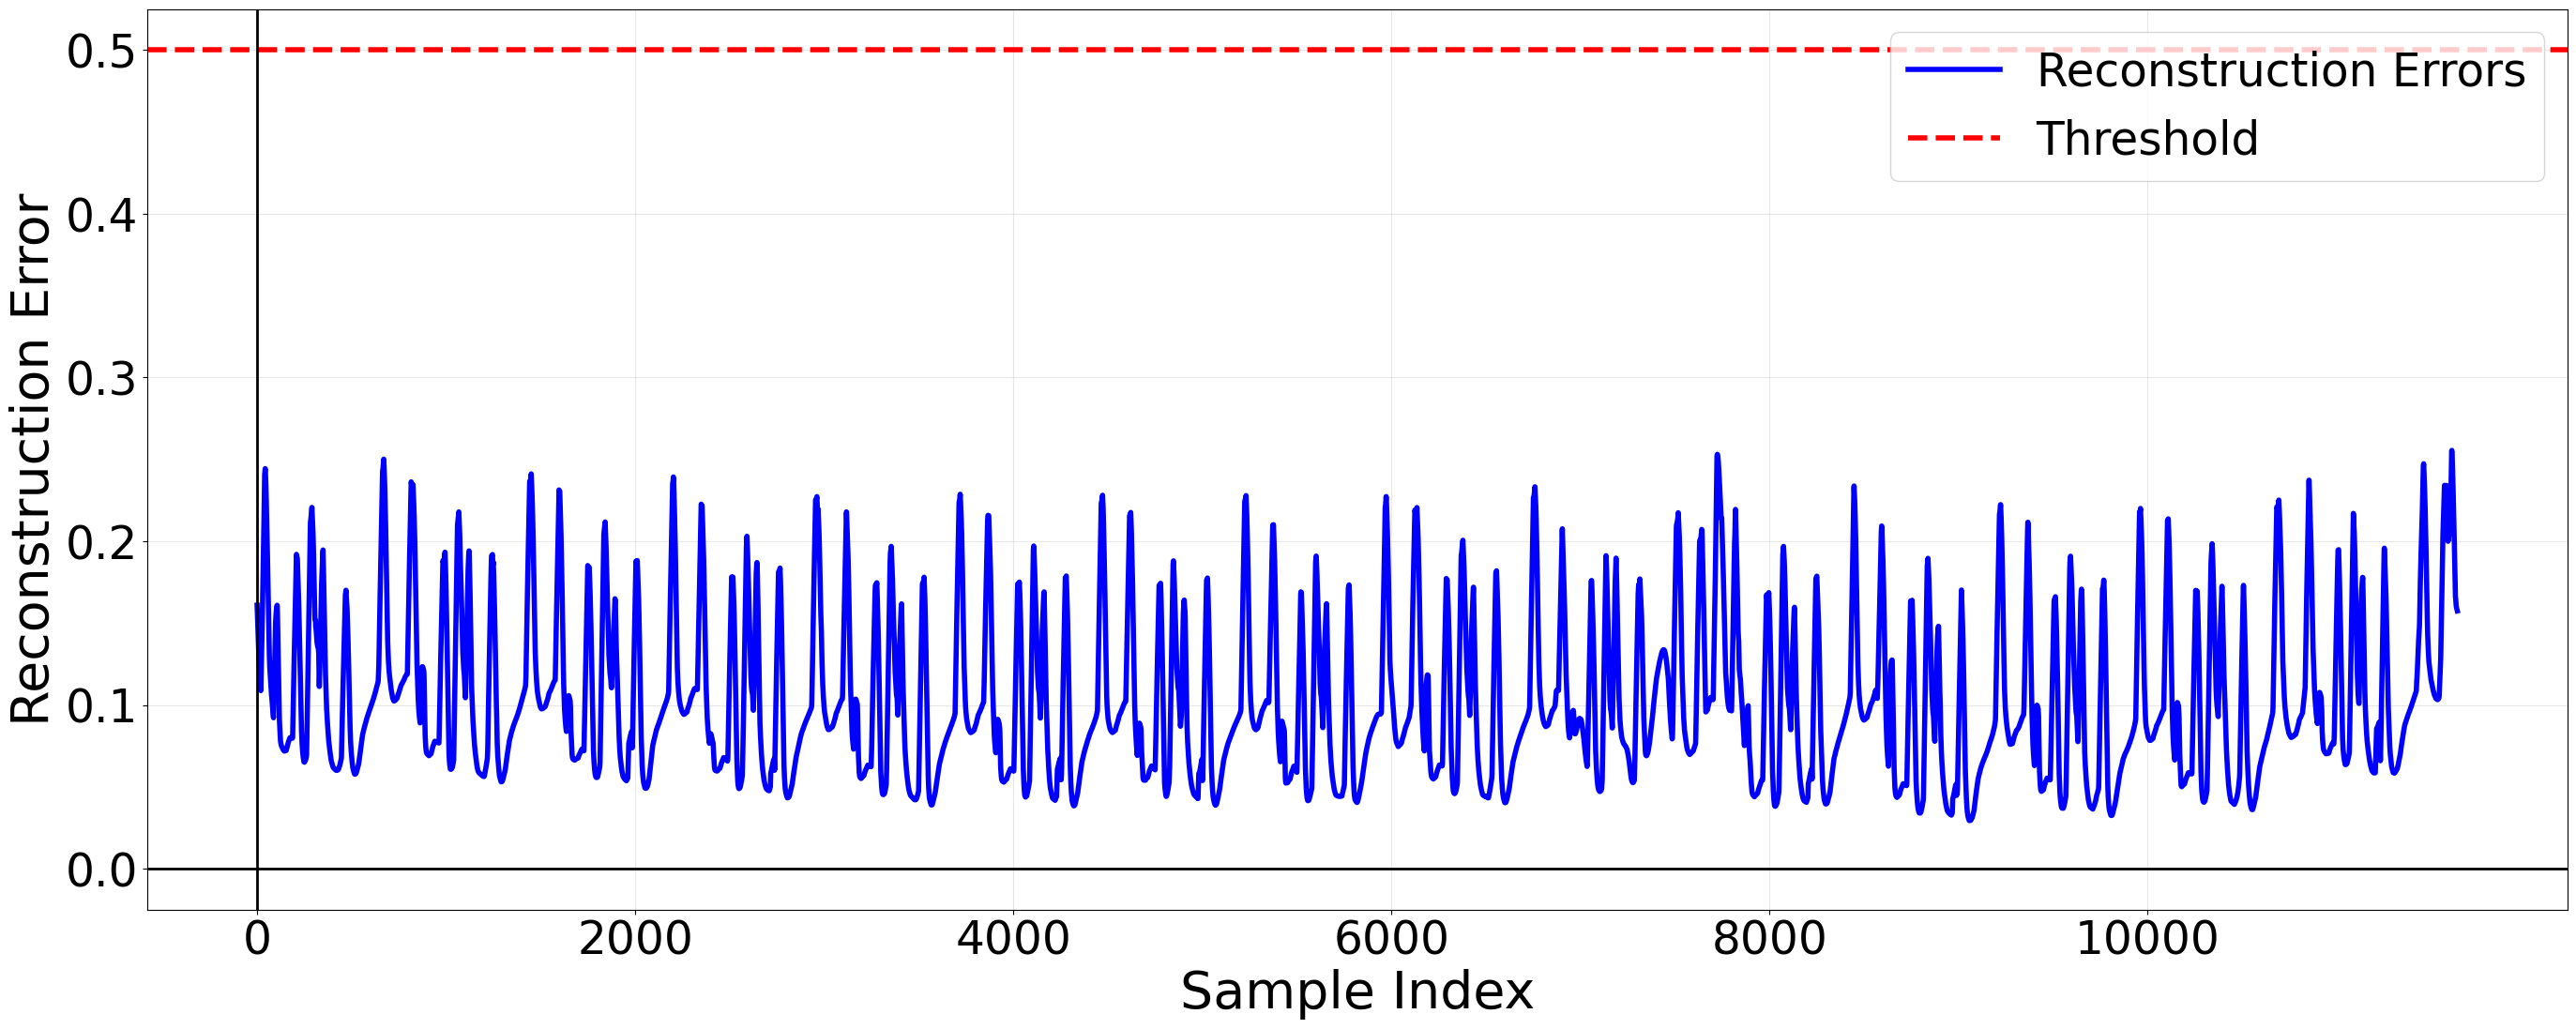

In [73]:
plot_reconstruction_errors_with_threshold(reconstruction_errors, threshold=threshold)

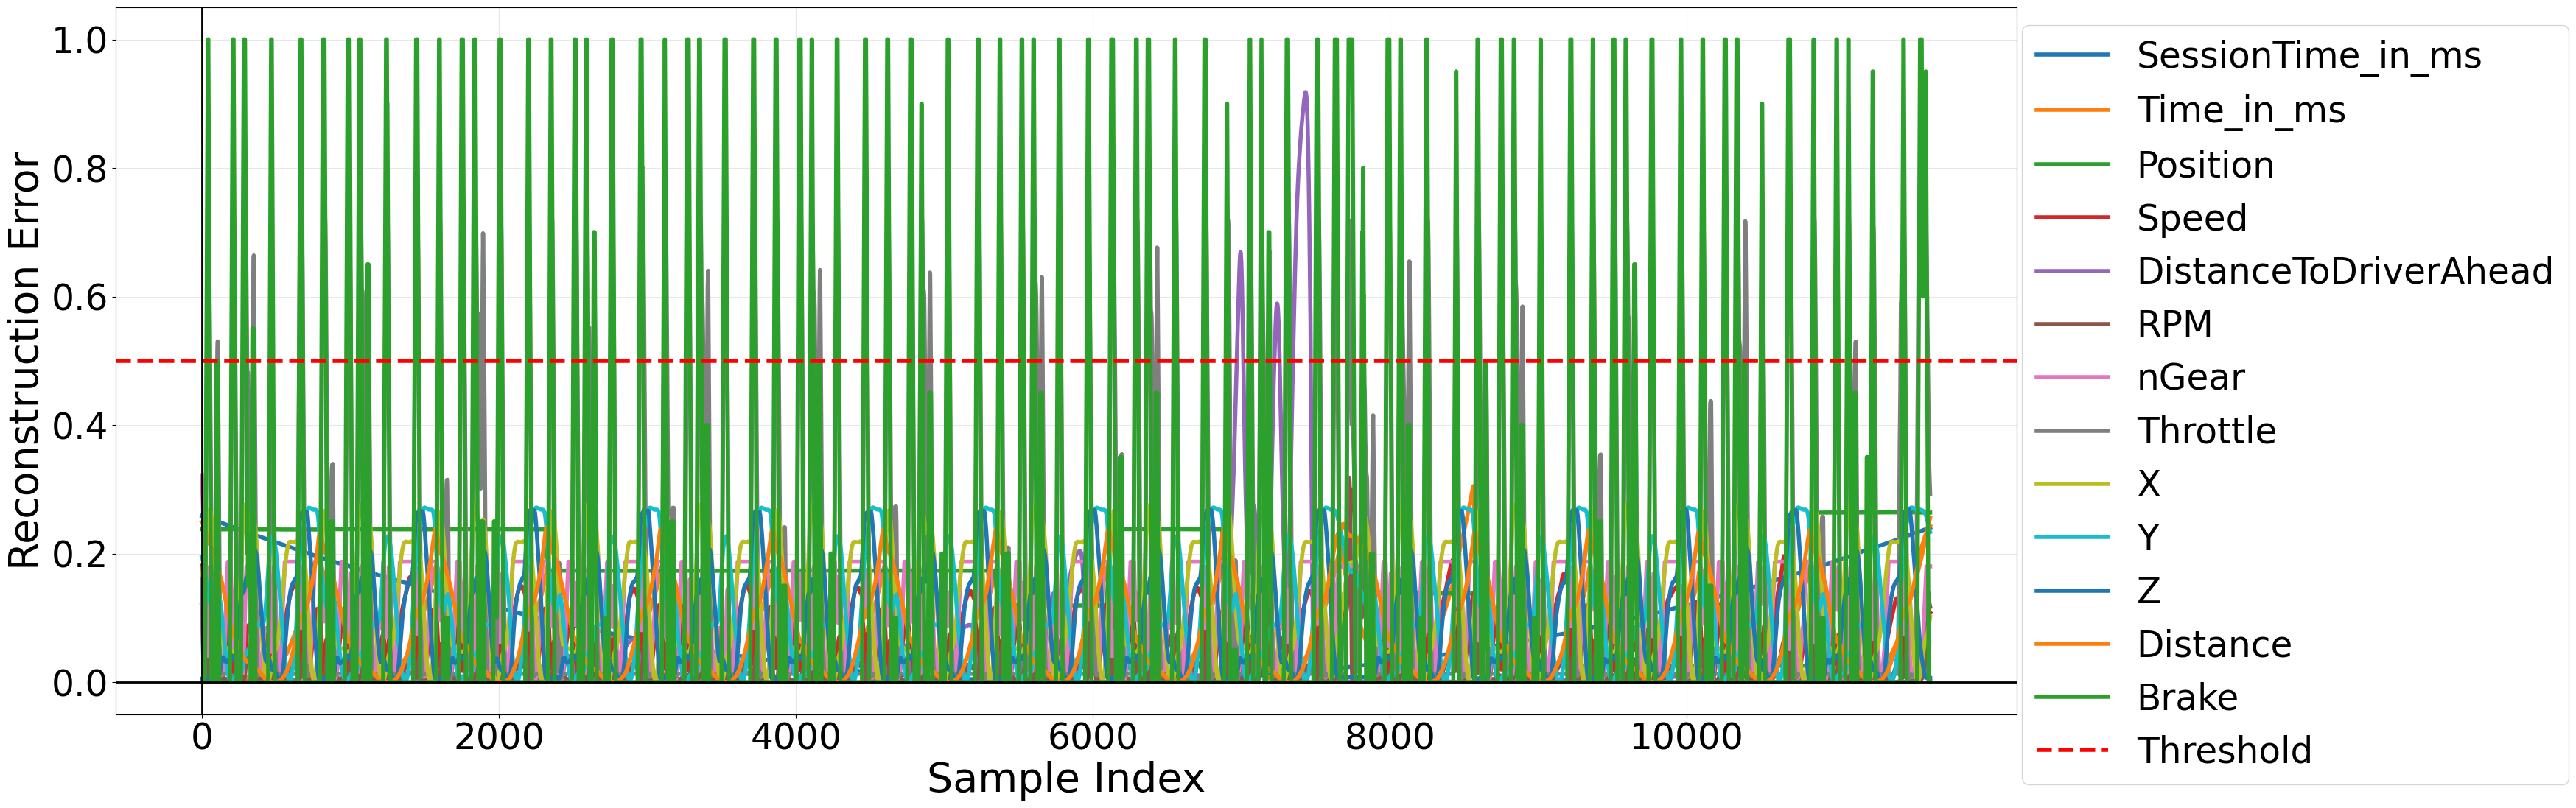

In [79]:
plot_reconstruction_errors_with_threshold(reconstruction_errors_by_feature_df, threshold=threshold)

In [63]:
# Find the indexes where anomalies are True
indexes = np.where(anomalies == True)[0]

# Group consecutive True blocks, allowing gaps of up to 5
blocks = []
block = []

for i in range(len(indexes)):
    if not block or indexes[i] <= block[-1] + 200:
        # Start a new block or extend the current one
        block.append(indexes[i])
    else:
        # Close the current block and start a new one
        blocks.append(block)
        block = [indexes[i]]

# Append the last block
if block:
    blocks.append(block)

print(blocks)


[]


In [64]:
len(blocks)

0

In [65]:
minutes_to_exlude = 5 # around first 3 laps
# Exclude first laps
first_lap_sequences = int((minutes_to_exlude * 60 * 1000) / 240)  # (minutes_to_exlude in milliseconds / length of a row)
count = 0
for block in blocks:
    if len(block) > 1:
        if block[0] > first_lap_sequences:
            print(f"Anomaly detected from timestep {block[0]}, with len {len(block)+20}")
            count += 1
print(f"Total anomalies detected: {count}")

Total anomalies detected: 0


In [66]:
blocks[-1][0]

IndexError: list index out of range

In [52]:
last_anomaly = blocks[-1][0] - 200
race_df[last_anomaly:]

,SessionTime,Time_in_ms,LapNumber,Position,Speed,AirTemp,Humidity,Pressure,TrackTemp,WindDirection,...,Z,Distance,TyreLife,Compound,Team,TrackStatus,Rainfall,Brake,DRS,Event
29513,0.993230,0.395433,1.0,1.0,0.562300,0.56,0.555556,0.0,0.405405,0.120112,...,0.603635,0.576594,0.375,4.0,1.0,1.0,0.0,1.0,0.0,1.0
29514,0.993252,0.396060,1.0,1.0,0.539936,0.56,0.555556,0.0,0.405405,0.120112,...,0.603573,0.577473,0.375,4.0,1.0,1.0,0.0,1.0,0.0,1.0
29515,0.993313,0.397792,1.0,1.0,0.517572,0.56,0.555556,0.0,0.405405,0.120112,...,0.603627,0.579883,0.375,4.0,1.0,1.0,0.0,1.0,0.0,1.0
29516,0.993326,0.398167,1.0,1.0,0.504792,0.56,0.555556,0.0,0.405405,0.120112,...,0.603635,0.580396,0.375,4.0,1.0,1.0,0.0,1.0,0.0,1.0
29517,0.993374,0.399524,1.0,1.0,0.495208,0.56,0.555556,0.0,0.405405,0.120112,...,0.603620,0.582189,0.375,4.0,1.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29708,0.999875,0.583614,1.0,1.0,0.242812,0.56,0.555556,0.0,0.405405,0.120112,...,0.109752,0.891106,0.375,4.0,1.0,1.0,0.0,0.0,0.0,1.0
29709,0.999946,0.585634,1.0,1.0,0.246006,0.56,0.555556,0.0,0.405405,0.120112,...,0.109752,0.892474,0.375,4.0,1.0,1.0,0.0,0.0,0.0,1.0
29710,0.999948,0.585684,1.0,1.0,0.249201,0.56,0.555556,0.0,0.405405,0.120112,...,0.109752,0.892509,0.375,4.0,1.0,1.0,0.0,0.0,0.0,1.0
29711,0.999997,0.587077,1.0,1.0,0.249201,0.56,0.555556,0.0,0.405405,0.120112,...,0.109752,0.893454,0.375,4.0,1.0,1.0,0.0,0.0,0.0,1.0


In [53]:
#check speed variance through windows
speed = race_df['Speed']
rpm = race_df['RPM']
speed_anomaly = speed[last_anomaly:]
rpm_anomaly = rpm[last_anomaly:]

max_threshold = 80/280
min_threshold = 80/370

#create a window of 20 samples that monitors the variance of the speed
speed_mean = []
rpm_var = []
speed_entry = False
for i in range(len(speed_anomaly)-20):
    speed_mean.append(np.mean(speed_anomaly[i:i+20]))
    rpm_var.append(np.var(rpm_anomaly[i:i+20]))
    if speed_mean[-1] > min_threshold and speed_mean[-1] < max_threshold and not speed_entry \
        and rpm_var[-1] < 0.002:
        # print(speed_var[-1])
        print(f"PIT ENTRY at index {i+last_anomaly}")
        speed_entry = True

# speed_var

# plt.figure(figsize=(24, 6))
# plt.plot(speed_mean, label="Speed Variance", color='blue', linewidth=1.5)
# # plt.plot(list(speed_anomaly), label="Speed", color='red', linewidth=1.5)
# plt.xlabel("Sample Index")
# race_df[last_anomaly:]

In [54]:
rpm_var

[0.0054643103,
 0.006075584,
 0.00681381,
 0.008017271,
 0.009045873,
 0.009696731,
 0.010272491,
 0.010953119,
 0.012243487,
 0.013632889,
 0.015137115,
 0.015063239,
 0.014835488,
 0.014288948,
 0.013537686,
 0.01305915,
 0.0122064985,
 0.011065476,
 0.00989103,
 0.008629369,
 0.006993829,
 0.005114871,
 0.003660267,
 0.0026169647,
 0.001821545,
 0.001346142,
 0.0012374045,
 0.0016086369,
 0.0023714749,
 0.0033619574,
 0.004544915,
 0.0060364865,
 0.007786373,
 0.0098210145,
 0.012653187,
 0.015897207,
 0.018788228,
 0.021266662,
 0.023267461,
 0.02570187,
 0.028551843,
 0.029588148,
 0.029100241,
 0.02833317,
 0.027171431,
 0.024846023,
 0.021758309,
 0.018701756,
 0.015728813,
 0.013154855,
 0.0109965755,
 0.008924414,
 0.007001108,
 0.005275021,
 0.003914484,
 0.0030892333,
 0.0024154978,
 0.0018905493,
 0.0015250741,
 0.0014748167,
 0.0014653031,
 0.0014241084,
 0.0014051466,
 0.0014870798,
 0.0015517174,
 0.0015772474,
 0.0014886203,
 0.0014045517,
 0.0013327557,
 0.0013364432,
